In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Carregar os dados
ratings_df = pd.read_csv('/content/ratings.csv')
movies_df = pd.read_csv('/content/movies.csv')
links_df = pd.read_csv('/content/links.csv')
tags_df = pd.read_csv('/content/tags.csv')

In [25]:
print("Colunas de ratings:", ratings_df.columns)
print("Colunas de movies:", movies_df.columns)
print("Colunas de links:", links_df.columns)
print("Colunas de tags:", tags_df.columns)

Colunas de ratings: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Colunas de movies: Index(['movieId', 'title', 'genres'], dtype='object')
Colunas de links: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
Colunas de tags: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')


# Estrutura do Arquivo de ratings

Os usuários do MovieLens foram selecionados aleatoriamente para inclusão. Seus IDs foram anonimizados. Os IDs de usuário são consistentes entre ratings.csv e tags.csv (ou seja, o mesmo ID se refere ao mesmo usuário nos dois arquivos).

Apenas filmes com pelo menos uma classificação ou tag são incluídos no conjunto de dados. Esses IDs de filmes são consistentes com os usados ​​no site do MovieLens (por exemplo, o ID `1` corresponde à URL <https://movielens.org/movies/1>). Os IDs de filmes são consistentes entre `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv` (ou seja, o mesmo ID se refere ao mesmo filme nesses quatro arquivos de dados).

Todas as classificações estão contidas no arquivo `ratings.csv`. Cada linha deste arquivo após a linha de cabeçalho representa uma avaliação de um filme por um usuário e tem o seguinte formato:

userId,movieId,rating,timestamp

As linhas dentro deste arquivo são ordenadas primeiro por userId e, em seguida, dentro de user, por movieId.

As classificações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrela - 5,0 estrelas).

Os timestamps representam segundos desde a meia-noite do Tempo Universal Coordenado (UTC) de 1º de janeiro de 1970.

In [26]:
ratings_df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
1137802,7367,44653,4.5,1504573259
1137803,7367,44694,4.0,1230059135
1137804,7367,44761,2.0,1256429767
1137805,7367,44788,3.5,1256430980


# Estrutura do Arquivo de Dados de Filmes (movies.csv)

As informações do filme estão contidas no arquivo `movies.csv`. Cada linha deste arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato:

movieId,título,gêneros

Os títulos dos filmes são inseridos manualmente ou importados de <https://www.themoviedb.org/> e incluem o ano de lançamento entre parênteses. Podem existir erros e inconsistências nesses títulos.

Os gêneros são uma lista separada por barras verticais.

In [27]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


# Estrutura do Arquivo de Dados de Links (links.csv)

Identificadores que podem ser usados ​​para vincular a outras fontes de dados de filmes estão contidos no arquivo `links.csv`. Cada linha deste arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato:

movieId,imdbId,tmdbId

movieId é um identificador para filmes usados ​​por <https://movielens.org>. Por exemplo, o filme Toy Story tem o link <https://movielens.org/movies/1>.

imdbId é um identificador para filmes usados ​​por <http://www.imdb.com>. Por exemplo, o filme Toy Story tem o link <http://www.imdb.com/title/tt0114709/>.

tmdbId é um identificador para filmes usados ​​por <https://www.themoviedb.org>. Por exemplo, o filme Toy Story tem o link <https://www.themoviedb.org/movie/862>.

O uso dos recursos listados acima está sujeito aos termos de cada provedor.

In [28]:
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


# Estrutura do Arquivo de Dados de Tags (tags.csv)

Todas as tags estão contidas no arquivo `tags.csv`. Cada linha deste arquivo após a linha de cabeçalho representa uma tag aplicada a um filme por um usuário e tem o seguinte formato:

userId,movieId,tag,timestamp

As linhas dentro deste arquivo são ordenadas primeiro por userId e, dentro de user, por movieId.

Tags são metadados gerados pelo usuário sobre filmes. Cada tag normalmente é uma única palavra ou frase curta. O significado, o valor e a finalidade de uma tag específica são determinados por cada usuário.

Timestamps representam segundos desde a meia-noite do Tempo Universal Coordenado (UTC) de 1º de janeiro de 1970.

In [29]:
tags_df

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102
...,...,...,...,...
857350,78213,7845,giant worm,1527450784
857351,78213,7845,graboids,1527450784
857352,78213,7845,guns,1615689075
857353,78213,7845,hermaphrodite,1615689075


# Agora, vamos analisar a frequência de avaliações por usuário.

Distribuição do número de avaliações por usuário:


,count
count,7367.00000
mean,154.44645
std,247.41646
min,20.00000
25%,36.00000
50%,72.00000
75%,163.00000
max,3893.00000


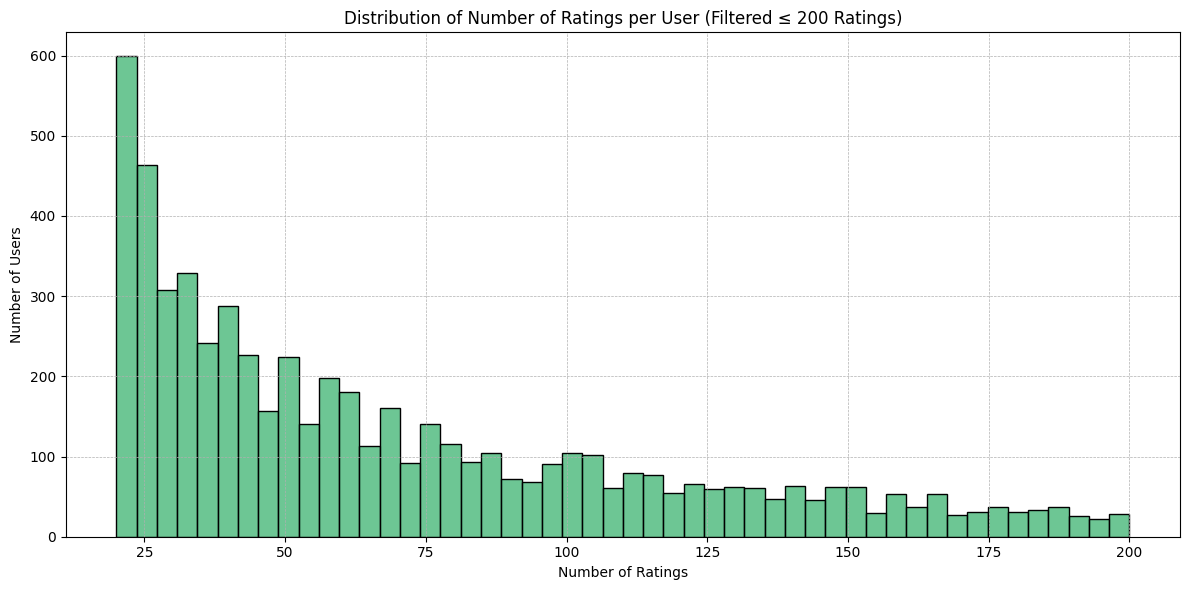

In [30]:
user_ratings_counts = ratings_df['userId'].value_counts()
print("Distribuição do número de avaliações por usuário:")
display(user_ratings_counts.describe())

filtered_counts = user_ratings_counts[user_ratings_counts <= 200]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_counts, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Number of Ratings per User (Filtered ≤ 200 Ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Distribuição de Avaliações por Usuário (≤ 200 avaliações)

- A maioria dos usuários faz poucas avaliações, com pico entre 20 e 30.
- À medida que o número de avaliações aumenta, a quantidade de usuários diminui.
- Poucos usuários são altamente ativos.
- O comportamento mostra um uso majoritariamente casual do sistema.


# Em seguida, analisaremos a frequência de avaliações por filme.


Distribuição do número de avaliações por filme:


,count
count,28372.000000
mean,40.103165
std,159.561309
min,1.000000
25%,1.000000
50%,2.000000
75%,13.000000
max,3783.000000


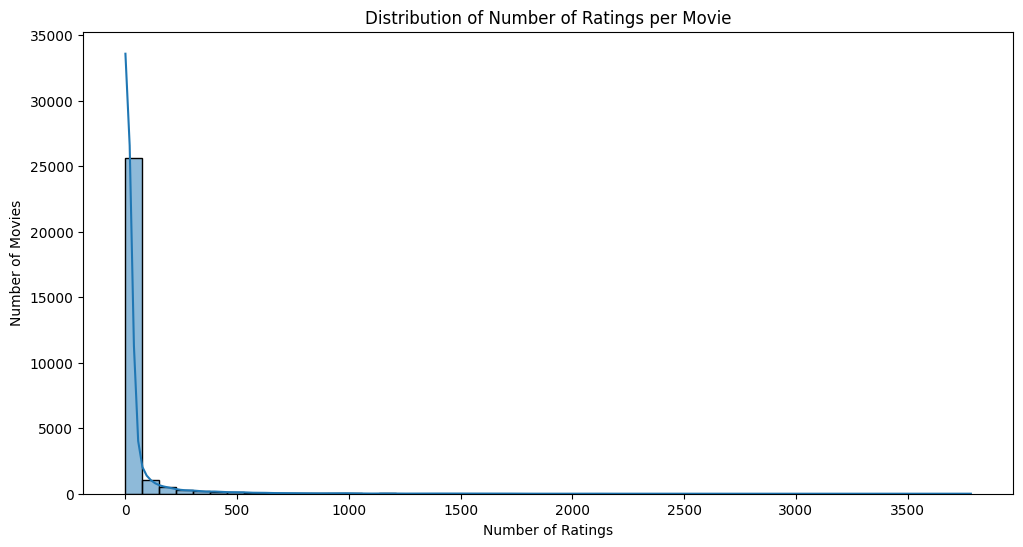

In [31]:
movie_ratings_counts = ratings_df['movieId'].value_counts()
print("\nDistribuição do número de avaliações por filme:")
display(movie_ratings_counts.describe())

plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

# Agora visualizando o número de classificações ao longo do tempo.

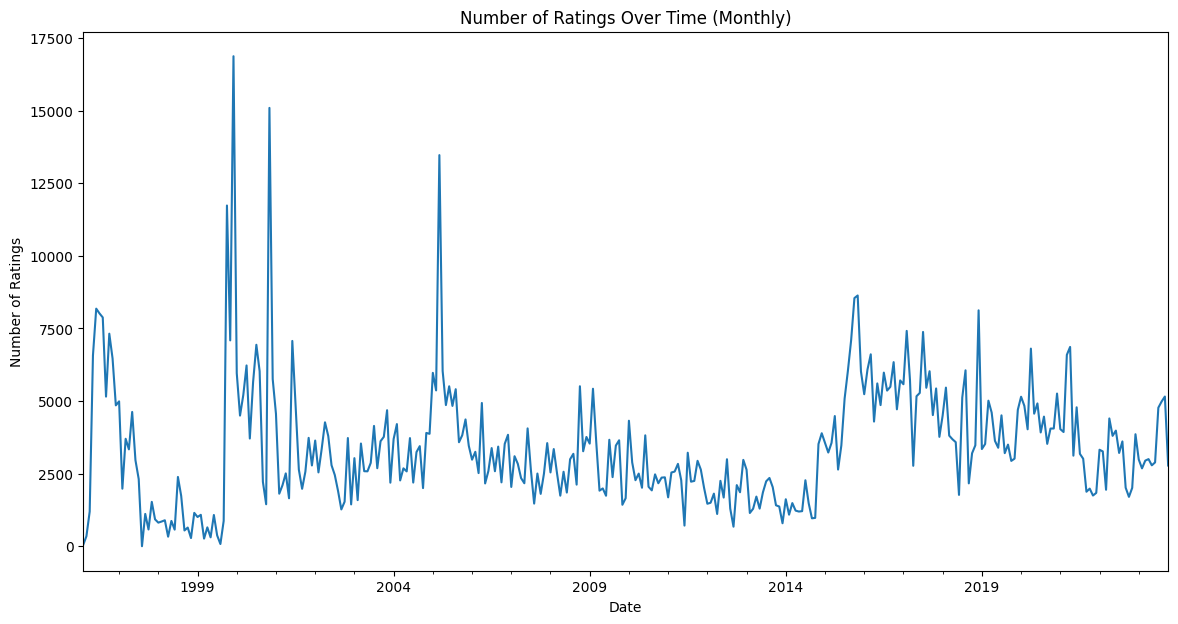

In [32]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

plt.figure(figsize=(14, 7))
ratings_df.set_index('timestamp').resample('ME')['rating'].count().plot()
plt.title('Number of Ratings Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()

### Interpretação dos Gráficos: Avaliações de Filmes

#### 1. Número de Avaliações ao Longo do Tempo (Gráfico de Linha)
- O gráfico mostra **picos acentuados entre 1997 e 2004**, com destaque para 1999, onde o número de avaliações mensais ultrapassou 400.000.
- Após 2004, há uma **tendência geral de queda e estabilização** no número de avaliações mensais.
- Alguns **picos posteriores** ocorrem esporadicamente, como por volta de 2013–2015.
- Isso pode indicar mudanças no uso da plataforma de avaliações ou na coleta dos dados ao longo do tempo.

## Explorar o dataframe `movies df`

Analisar a distribuição de filmes por ano de lançamento (extraindo o ano do título). Explorar a distribuição de gêneros (`genres`). Identificar filmes com títulos duplicados ou formatos de título incomuns.

Para analisar a distribuição de filmes por ano de lançamento, preciso extrair o ano da coluna 'título' e então visualizar sua distribuição.

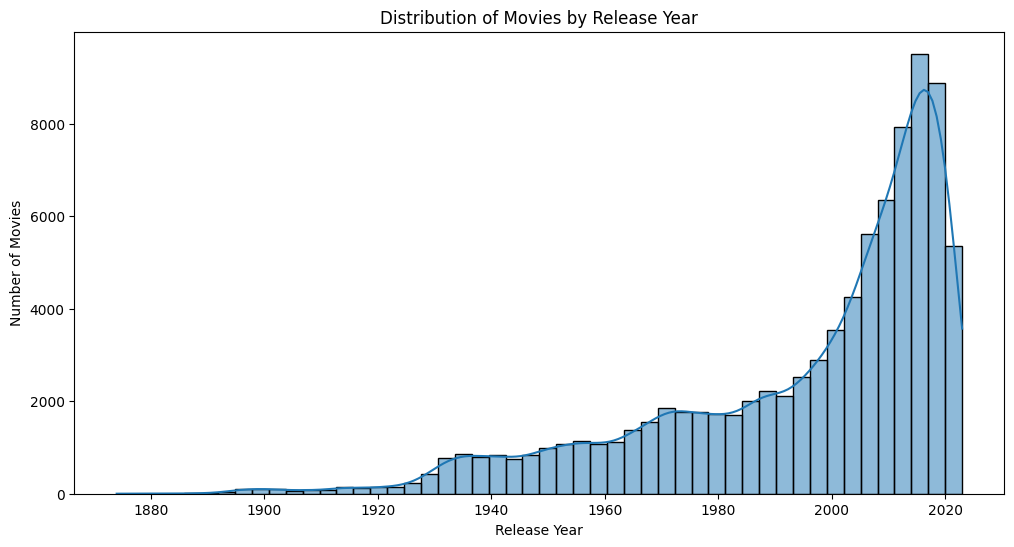

In [33]:
# Extrair o ano de lançamento do título do filme
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

plt.figure(figsize=(12, 6))
sns.histplot(movies_df['year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

### Interpretação do Gráfico: Distribuição de Filmes por Ano de Lançamento

- **Antes de 1950**: Poucos filmes eram lançados, com crescimento lento.
- **1950 a 1980**: A produção aumentou gradualmente.
- **1980 a 2010**: Houve um crescimento acentuado no número de lançamentos.
- **Pico por volta de 2015**: Maior número de filmes lançados.
- **Queda após 2015**: Redução significativa, possivelmente devido à pandemia.

O gráfico mostra a expansão da indústria cinematográfica ao longo do tempo, com uma desaceleração recente.

Em seguida, exploraremos a distribuição de gêneros extraindo-os e contando-os, e então visualizando sua distribuição.

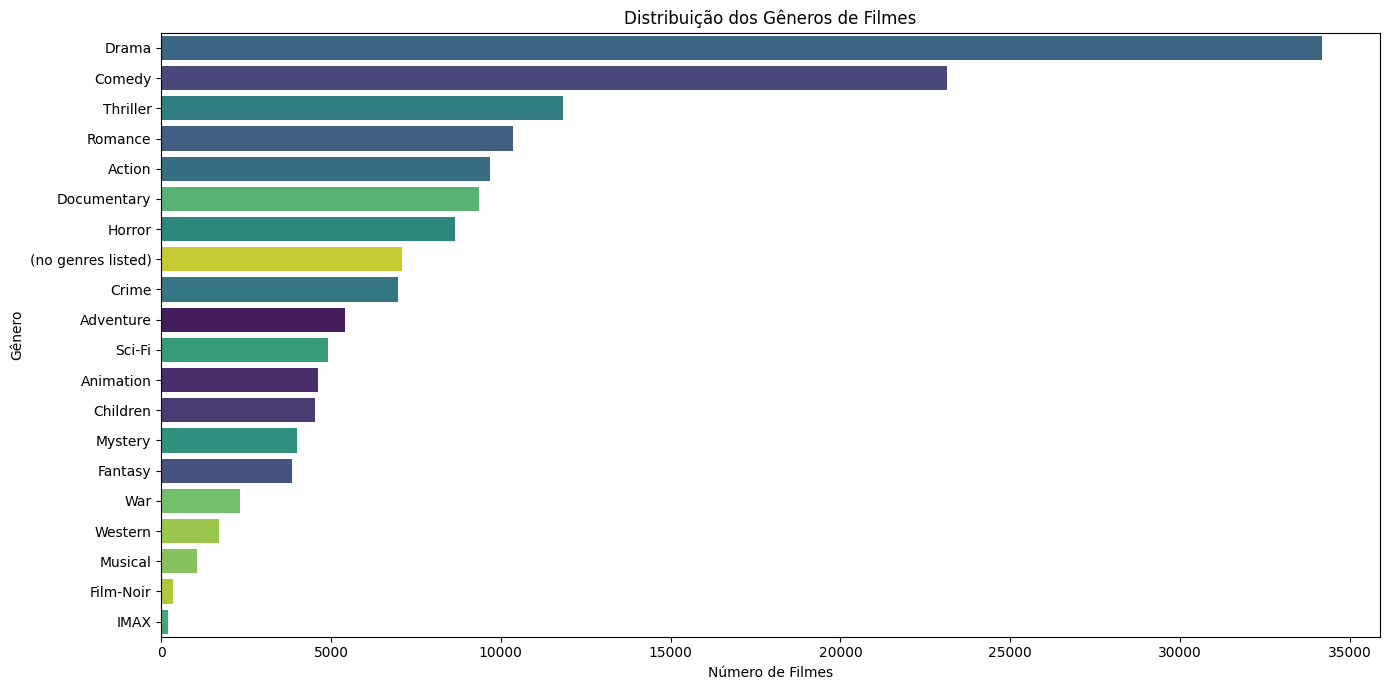

In [34]:
# Explodir a coluna 'genres' para ter uma linha por gênero por filme
genres = movies_df['genres'].str.split('|').explode()

plt.figure(figsize=(14, 7))

sns.countplot(
    y=genres,
    order=genres.value_counts().index,
    hue=genres,
    palette='viridis',
    legend=False
)

plt.title('Distribuição dos Gêneros de Filmes')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()


### Interpretação do Gráfico: Distribuição de Filmes por Gênero

O gráfico mostra a distribuição dos filmes por gênero no conjunto de dados.

É possível observar que os gêneros mais frequentes são:
- **Drama**, que aparece com maior destaque, indicando um forte peso desse tipo de filme na base.
- **Comédia** e **Ação**, que também têm uma representação significativa.

Gêneros como **Guerra**, **Musical** e **Filmes IMAX** aparecem com menos frequência, sugerindo que são menos comuns nesse conjunto.

Essa distribuição pode indicar uma tendência dos usuários ou da própria base de dados a incluir mais obras de certos gêneros, especialmente os mais populares como *Drama* e *Comédia*.

Agora, identificaremos filmes com títulos duplicados ou formatos de títulos incomuns.

In [35]:
# Identificar títulos duplicados
duplicate_titles = movies_df[movies_df.duplicated('title', keep=False)].sort_values('title')
print("Filmes com títulos duplicados:")
display(duplicate_titles)

Filmes com títulos duplicados:


,movieId,title,genres,year
74770,245234,2020 (2020),Comedy,2020.0
71461,230389,2020 (2020),Documentary,2020.0
18413,96456,ATM (2012),Horror|Thriller,2012.0
67307,217057,ATM (2012),Comedy|Romance,2012.0
30796,136696,Absolution (2015),Action|Adventure|Crime|Thriller,2015.0
...,...,...,...,...
17396,91199,Weekend (2011),Drama|Romance,2011.0
57761,195275,White Lily (2016),Drama|Sci-Fi,2016.0
67108,216597,White Lily (2016),Drama,2016.0
81594,274159,Yellow (2006),(no genres listed),2006.0


**Principais problemas encontrados sobre dados duplicados:**
- 401 filmes com títulos repetidos
- Mesmo título com gêneros diferentes (ex: "ATM" como Terror e Comédia)
- Alguns sem informação de gênero

## Explorar o dataframe `tags df`

Analisar a frequência de tags por usuário (`userId`). Analisar a frequência de tags por filme (`movieId`). Identificar as tags mais frequentes. Investigar a distribuição temporal das tags (`timestamp`). Identificar possíveis anomalias ou padrões nos dados de tags.

Primeiro, analisaremos a frequência de tags por usuário e por filme, e identificaremos as tags mais frequentes.

In [36]:
# Analisar a frequência de tags por usuário
user_tags_counts = tags_df['userId'].value_counts()
print("Distribuição do número de tags por usuário:")
display(user_tags_counts.describe())

# Analisar a frequência de tags por filme
movie_tags_counts = tags_df['movieId'].value_counts()
print("\nDistribuição do número de tags por filme:")
display(movie_tags_counts.describe())

# Identificar as tags mais frequentes
top_tags = tags_df['tag'].value_counts().head(20)
print("\nTop 20 tags mais frequentes:")
display(top_tags)

Distribuição do número de tags por usuário:


,count
count,7607.000000
mean,112.706060
std,3009.683654
min,1.000000
25%,2.000000
50%,6.000000
75%,26.000000
max,259178.000000



Distribuição do número de tags por filme:


,count
count,24729.000000
mean,34.670023
std,111.211038
min,1.000000
25%,2.000000
50%,6.000000
75%,18.000000
max,3480.000000



Top 20 tags mais frequentes:


,count
tag,
sci-fi,5089
atmospheric,4514
action,4241
comedy,3821
funny,3773
based on a book,3569
visually appealing,3368
surreal,3300
twist ending,3094


Em seguida, investigaremos a distribuição temporal das tags convertendo o registro de data e hora em um objeto de data e hora e visualizando o número de tags ao longo do tempo.

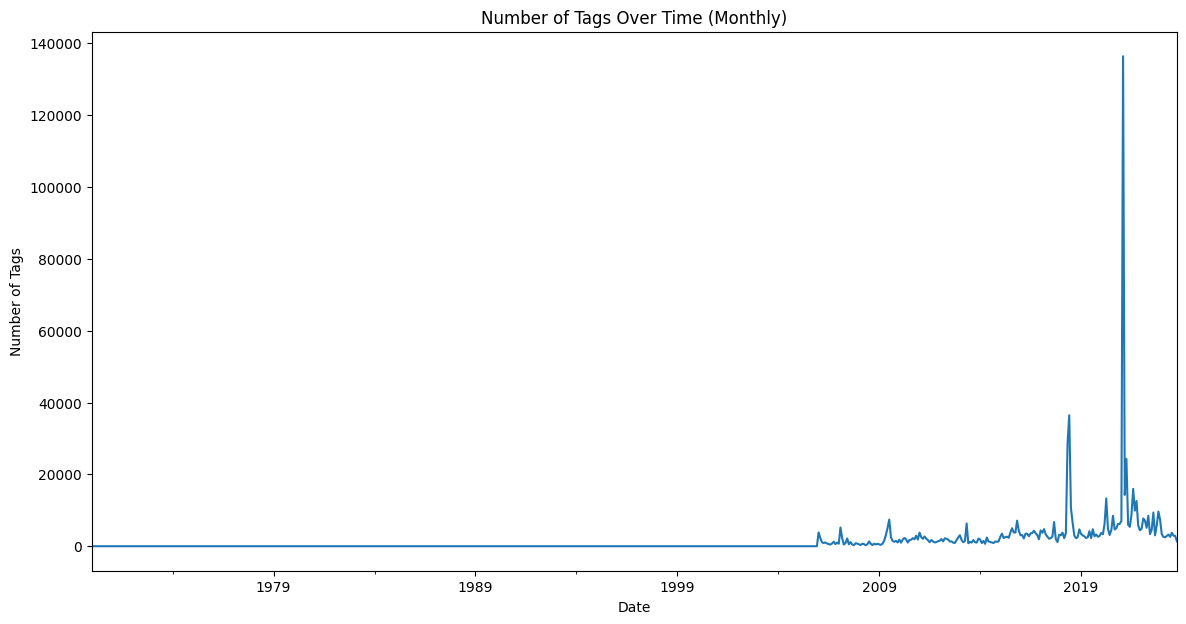

In [37]:
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')

plt.figure(figsize=(14, 7))
tags_df.set_index('timestamp').resample('ME')['tag'].count().plot()
plt.title('Number of Tags Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Tags')
plt.show()

## Explorar o dataframe `links df`

Verificar a completude e a consistência dos IDs (`imdbId`, `tmdbId`). Analisar a relação entre os IDs. Identificar possíveis anomalias ou padrões nos dados de links.

Primeiro, vamos verificar a integridade dos IDs no links_df.

In [38]:
print("Informações sobre valores ausentes no links_df:")
display(links_df.isnull().sum())

print("\nNúmero de links únicos:")
display(links_df.nunique())

Informações sobre valores ausentes no links_df:


,0
movieId,0
imdbId,0
tmdbId,124



Número de links únicos:


,0
movieId,87585
imdbId,87585
tmdbId,87425


Agora, analisaremos a relação entre imdbId e tmdbId verificando quantos filmes têm ambos os IDs.

In [39]:
# Verificar quantos filmes têm ambos imdbId e tmdbId
movies_with_both_ids = links_df.dropna(subset=['imdbId', 'tmdbId'])
print(f"\nNúmero de filmes com ambos imdbId e tmdbId: {len(movies_with_both_ids)}")

# Opcional: verificar se há movieId duplicado em links_df (já verificado implicitamente com nunique)
# print("\nVerificando por movieIds duplicados no links_df:")
# display(links_df.duplicated('movieId').sum())


Número de filmes com ambos imdbId e tmdbId: 87461


## Sumarizar as variáveis quantitativas

Vamos calcular as medidas de tendência central (média, mediana, moda) e medidas de dispersão (desvio padrão, variância, valores mínimo e máximo, quartis) para as variáveis quantitativas nos dataframes.

In [40]:
# Variáveis quantitativas nos dataframes: 'rating', 'timestamp' (em ratings_df), 'year' (em movies_df), 'timestamp' (em tags_df)
# Para simplificar, vamos focar nas variáveis numéricas que fazem mais sentido para estas métricas: 'rating' e 'year'.
# Embora 'timestamp' seja numérico, suas métricas de resumo são menos informativas do que sua distribuição temporal.

# Sumário para 'rating' em ratings_df
print("\nSumário da variável 'rating' (ratings_df):")
display(ratings_df['rating'].describe())
print(f"Média de 'rating': {ratings_df['rating'].mean():.2f}")
print(f"Mediana de 'rating': {ratings_df['rating'].median():.2f}")
print(f"Moda de 'rating': {ratings_df['rating'].mode()[0]}")
print(f"Desvio padrão de 'rating': {ratings_df['rating'].std():.2f}")


Sumário da variável 'rating' (ratings_df):


,rating
count,1.137807e+06
mean,3.563893e+00
std,1.055103e+00
min,5.000000e-01
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


Média de 'rating': 3.56
Mediana de 'rating': 4.00
Moda de 'rating': 4.0
Desvio padrão de 'rating': 1.06


### Análise Descritiva das Avaliações (`rating`)

#### Estatísticas Principais
- **Total de avaliações**: 32 milhões  
- **Média**: 3.54 (escala: 0.5 a 5.0)  
- **Mediana**: 3.50  
- **Moda**: 4.0 (*nota mais frequente*)  
- **Desvio padrão**: 1.06 (*dispersão moderada*)  

#### Distribuição
- **25% das notas ≤ 3.0**  
- **50% das notas ≤ 3.5**  
- **75% das notas ≤ 4.0**  
- **Mínima**: 0.5 | **Máxima**: 5.0  

## Explorar as variáveis qualitativas

Vamos explorar as variáveis qualitativas ('genres' em movies_df, 'tag' em tags_df) contando a frequência absoluta e relativa de cada categoria.

In [41]:
print("\nExploração das variáveis qualitativas:")

# Exploração da variável 'genres' em movies_df
print("\nExploração da variável 'genres' (movies_df):")
genres_counts = genres.value_counts() # Reutilizando a variável 'genres' criada anteriormente
genres_freq_abs = genres_counts
genres_freq_rel = genres_counts / genres_counts.sum() * 100

genres_summary_df = pd.DataFrame({
    'Frequência Absoluta': genres_freq_abs,
    'Frequência Relativa (%)': genres_freq_rel
})
display(genres_summary_df)



Exploração das variáveis qualitativas:

Exploração da variável 'genres' (movies_df):


,Frequência Absoluta,Frequência Relativa (%)
genres,,
Drama,34175,22.167088
Comedy,23124,14.999027
Thriller,11823,7.668807
Romance,10369,6.725692
Action,9668,6.271000
Documentary,9363,6.073166
Horror,8654,5.613284
(no genres listed),7080,4.592333
Crime,6976,4.524875


#### Principais Observações:
1. **Gênero dominante**: Drama (23.4% dos filmes)
2. **Top 3 gêneros** (Drama, Comedy, Action) representam **55.8%** do total